## Compare the dataset from the paper with the newly created datasets

In [10]:
import numpy as np
import pandas as pd 
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from mlxtend.evaluate import permutation_test
def stat_testing(new_score, baseline_score):
    """
    Compute a p-value between two sets using permutation testing 
    to determined statistical significance. In this case,
    assess whether the ML performance is greater than the baseline.
    """
    p_value = permutation_test(new_score,
                              baseline_score,
                             'x_mean != y_mean',
                              method='approximate',
                               num_rounds=1000,
                               seed=0)
    return p_value

In [11]:
def load_ml_data(lead_time = 'first_hour', 
                 mode = 'train',
                 cols_to_drop = ['label', 'obj_centroid_x', 
                                 'obj_centroid_y', 'Run Date', 
                                 'forecast_time_index'], 
                target_col = 'hail_severe_3km_obj_match',

                ): 
    """ Loads the ML dataset. """
    # Target Var : [tornado|wind|hail]_[severe|sig_severe]_[3km, 9km, 15km, 30km]_[obj_match | ]
    #base_path = '/work/mflora/ML_DATA/MLDATA'
    #file_path = join(base_path, f'wofs_ml_severe__{lead_time}__{mode}_data.feather')
    
    base_path = '/work/mflora/ML_DATA/DATA'
    file_path = join(base_path, f'wofs_ml_severe__{lead_time}__data.feather')
    df = pd.read_feather(file_path)

    ###print(list(df.columns))
    
    metadata = df[['Run Date', 'forecast_time_index', 'Initialization Time', 'label', 'obj_centroid_y', 
                  'obj_centroid_x']]
    
    index = list(df.columns).index('tornado_severe_0km')
    possible_features = list(df.columns)[:index]

    drop_vars = ['QVAPOR', 'freezing_level', 'stp', 'okubo_weiss', 'Initialization Time', 
                 'qv_2', 'srh_0to500'
                ]
    
    features = [f for f in possible_features if f not in cols_to_drop]
    features = [f for f in features if not any([d in f for d in drop_vars])]
    
    X = df[features]
    y = df[target_col]

    return X,y, metadata 

In [12]:
def load_original_data(target, mode='training'):
    
    target = f'matched_to_{target}_0km'
    
    df = pd.read_feather(
    f'/work/mflora/ML_DATA/DATA/original_first_hour_{mode}_{target}_data.feather')
    
    metadata = ['label', 'Run Time', 'Run Date', 'FCST_TIME_IDX']
    targets = ['matched_to_severe_hail_0km',
     'matched_to_severe_hail_15km',
     'matched_to_LSRs_0km',
     'matched_to_LSRs_15km',
     'matched_to_severe_wind_0km',
     'matched_to_severe_wind_15km',
     'matched_to_tornado_0km',
     'matched_to_tornado_15km']
    features = [f for f in df.columns if f not in targets+metadata]

    X = df[features].astype(float)
    y = df[target].astype(float).values
    
    dates = df['Run Date'].apply(str)
    
    return X, y, dates

In [13]:
# Convert New to Old 
def convert(X, y, new_dates, old_dates):
    # Get the indices of dates within the old dates 
    cond = new_dates.isin(np.unique(old_dates))
    
    inds = np.where(cond==True)[0]
    
    X = X.iloc[inds]
    y = y[inds]
    new_dates = new_dates[inds]
    
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    new_dates.reset_index(drop=True, inplace=True)
    
    return X, y, new_dates

In [14]:
# Load the original training and testing dataset. 
target = 'severe_wind'
target_col = 'wind_severe_0km'

X, y, metadata = load_ml_data(target_col=target_col, 
                                   lead_time = 'first_hour', mode = None )
    
X_train, y_train, train_dates = load_original_data(mode='training', target=target)
X_test, y_test, test_dates = load_original_data(mode='testing', target=target)
    
all_dates = metadata['Run Date'].apply(str)
X_train_new, y_train_new, train_dates_new = convert(X, y, all_dates, train_dates)
X_test_new, y_test_new, test_dates_new = convert(X, y, all_dates, train_dates)

In [15]:
features= list(X_train.columns)

In [65]:
def name_changer(feature):

    # Changing from the old dataset to the new dataset. 
    name_changes = {'geopotential_height_500mb' : 'geo_hgt_500',
                'geopotential_height_700mb' : 'geo_hgt_700',
                'geopotential_height_850mb' : 'geo_hgt_850',
                'dewpoint_850mb' : 'td_850',
                'dewpoint_500mb' : 'td_500',
                'dewpoint_700mb' : 'td_700',
                '10-m_bulk_shear' : '10-500m_bulkshear',
                'cloud_top_temp' : 'ctt',
                'temperature_850mb' : 'temperature_850',
                'temperature_500mb' : 'temperature_500',
                'temperature_700mb' : 'temperature_700',
                'dbz_3to5km_max'        : 'dbz_3to5', 
                'dbz_1to3km_max'        : 'dbz_1to3', 
                'divergence_10m'    : 'div_10m',
                'bouyancy'          : 'buoyancy',
                'th_e_ml'           : 'theta_e',
               }

    if 'time' in feature and 'th' in feature:
        var, stat = feature.split('_time')
        time, stat = stat.split('ens')
        ens_stat = stat.split('_of')[0]#.replace('_', '')
    
        #'uh_0to2__time_max__amp_ens_mean'
        new_feature = f"{name_changes.get(var, var)}__time_{time.replace('_', '')}__amp_ens{ens_stat}"
        #print(new_feature)
    
    elif 'ens' in feature:
        var, ens_stat = feature.split('_ens')
        ens_stat = ens_stat.replace('_spatial_mean', '')

        new_feature = f'{name_changes.get(var, var)}__ens{ens_stat}__spatial_mean'
        if 'time' in feature:
            new_feature = new_feature.replace('_time', '__time')
        #print(new_feature)
    else:
        new_feature = feature 
    
    
    return new_feature

In [42]:
name_changer('uh_0to2_time_max_ens_mean_spatial_mean')

'uh_0to2__time_max__ens_mean__spatial_mean'

In [17]:
list(X_train.columns)

['srh_0to1_ens_mean_spatial_mean',
 'srh_0to3_ens_mean_spatial_mean',
 'cape_ml_ens_mean_spatial_mean',
 'cin_ml_ens_mean_spatial_mean',
 'shear_u_0to6_ens_mean_spatial_mean',
 'shear_v_0to6_ens_mean_spatial_mean',
 'shear_u_0to1_ens_mean_spatial_mean',
 'shear_v_0to1_ens_mean_spatial_mean',
 'lcl_ml_ens_mean_spatial_mean',
 'th_e_ml_ens_mean_spatial_mean',
 'u_10_ens_mean_spatial_mean',
 'v_10_ens_mean_spatial_mean',
 'mid_level_lapse_rate_ens_mean_spatial_mean',
 'low_level_lapse_rate_ens_mean_spatial_mean',
 'temperature_850mb_ens_mean_spatial_mean',
 'temperature_700mb_ens_mean_spatial_mean',
 'temperature_500mb_ens_mean_spatial_mean',
 'geopotential_height_850mb_ens_mean_spatial_mean',
 'geopotential_height_700mb_ens_mean_spatial_mean',
 'geopotential_height_500mb_ens_mean_spatial_mean',
 'dewpoint_850mb_ens_mean_spatial_mean',
 'dewpoint_700mb_ens_mean_spatial_mean',
 'dewpoint_500mb_ens_mean_spatial_mean',
 'uh_0to2_time_max_ens_mean_spatial_mean',
 'uh_2to5_time_max_ens_mean_sp

In [18]:
list(X_train_new.columns)

['theta_e__ens_mean__spatial_mean',
 'u_10__ens_mean__spatial_mean',
 'v_10__ens_mean__spatial_mean',
 'temperature_850__ens_mean__spatial_mean',
 'temperature_700__ens_mean__spatial_mean',
 'temperature_500__ens_mean__spatial_mean',
 'td_850__ens_mean__spatial_mean',
 'td_700__ens_mean__spatial_mean',
 'td_500__ens_mean__spatial_mean',
 'mid_level_lapse_rate__ens_mean__spatial_mean',
 'low_level_lapse_rate__ens_mean__spatial_mean',
 'geo_hgt_850__ens_mean__spatial_mean',
 'geo_hgt_500__ens_mean__spatial_mean',
 'geo_hgt_700__ens_mean__spatial_mean',
 'srh_0to1__ens_mean__spatial_mean',
 'srh_0to3__ens_mean__spatial_mean',
 'cape_ml__ens_mean__spatial_mean',
 'cin_ml__ens_mean__spatial_mean',
 'shear_u_0to6__ens_mean__spatial_mean',
 'shear_v_0to6__ens_mean__spatial_mean',
 'shear_u_0to1__ens_mean__spatial_mean',
 'shear_v_0to1__ens_mean__spatial_mean',
 'shear_u_3to6__ens_mean__spatial_mean',
 'shear_v_3to6__ens_mean__spatial_mean',
 'lcl_ml__ens_mean__spatial_mean',
 'comp_dz__time_m

In [19]:
def subsampler(x, size=50000):
    inds = np.random.choice(len(x), size=size)
    return x[inds]

In [66]:
features = list(X_train.columns)

different_features = []
for feature in features:
    data = X_train[feature]
    try:
        new_data = X_train_new[name_changer(feature)]
    
        data = subsampler(data, size=10000)
        new_data = subsampler(new_data, size=10000)
    
        p_val = stat_testing(new_data, data)
        if p_val < 0.001:
            outcome = 'Different'
            different_features.append(feature)
        else:
            outcome = 'Same'
    
        print(f'Feature: {feature} ..... P-value: {p_val:.4f} ... {outcome}')
    except:
        print(feature)
        continue

Feature: srh_0to1_ens_mean_spatial_mean ..... P-value: 0.9291 ... Same
Feature: srh_0to3_ens_mean_spatial_mean ..... P-value: 0.0010 ... Different
Feature: cape_ml_ens_mean_spatial_mean ..... P-value: 0.0010 ... Different
Feature: cin_ml_ens_mean_spatial_mean ..... P-value: 0.0010 ... Different
Feature: shear_u_0to6_ens_mean_spatial_mean ..... P-value: 0.0010 ... Different
Feature: shear_v_0to6_ens_mean_spatial_mean ..... P-value: 0.5105 ... Same
Feature: shear_u_0to1_ens_mean_spatial_mean ..... P-value: 0.0010 ... Different
Feature: shear_v_0to1_ens_mean_spatial_mean ..... P-value: 0.0010 ... Different
Feature: lcl_ml_ens_mean_spatial_mean ..... P-value: 0.0010 ... Different
Feature: th_e_ml_ens_mean_spatial_mean ..... P-value: 0.0010 ... Different
Feature: u_10_ens_mean_spatial_mean ..... P-value: 0.3686 ... Same
Feature: v_10_ens_mean_spatial_mean ..... P-value: 0.5604 ... Same
Feature: mid_level_lapse_rate_ens_mean_spatial_mean ..... P-value: 0.0010 ... Different
Feature: low_level

In [53]:
len(different_features)

55

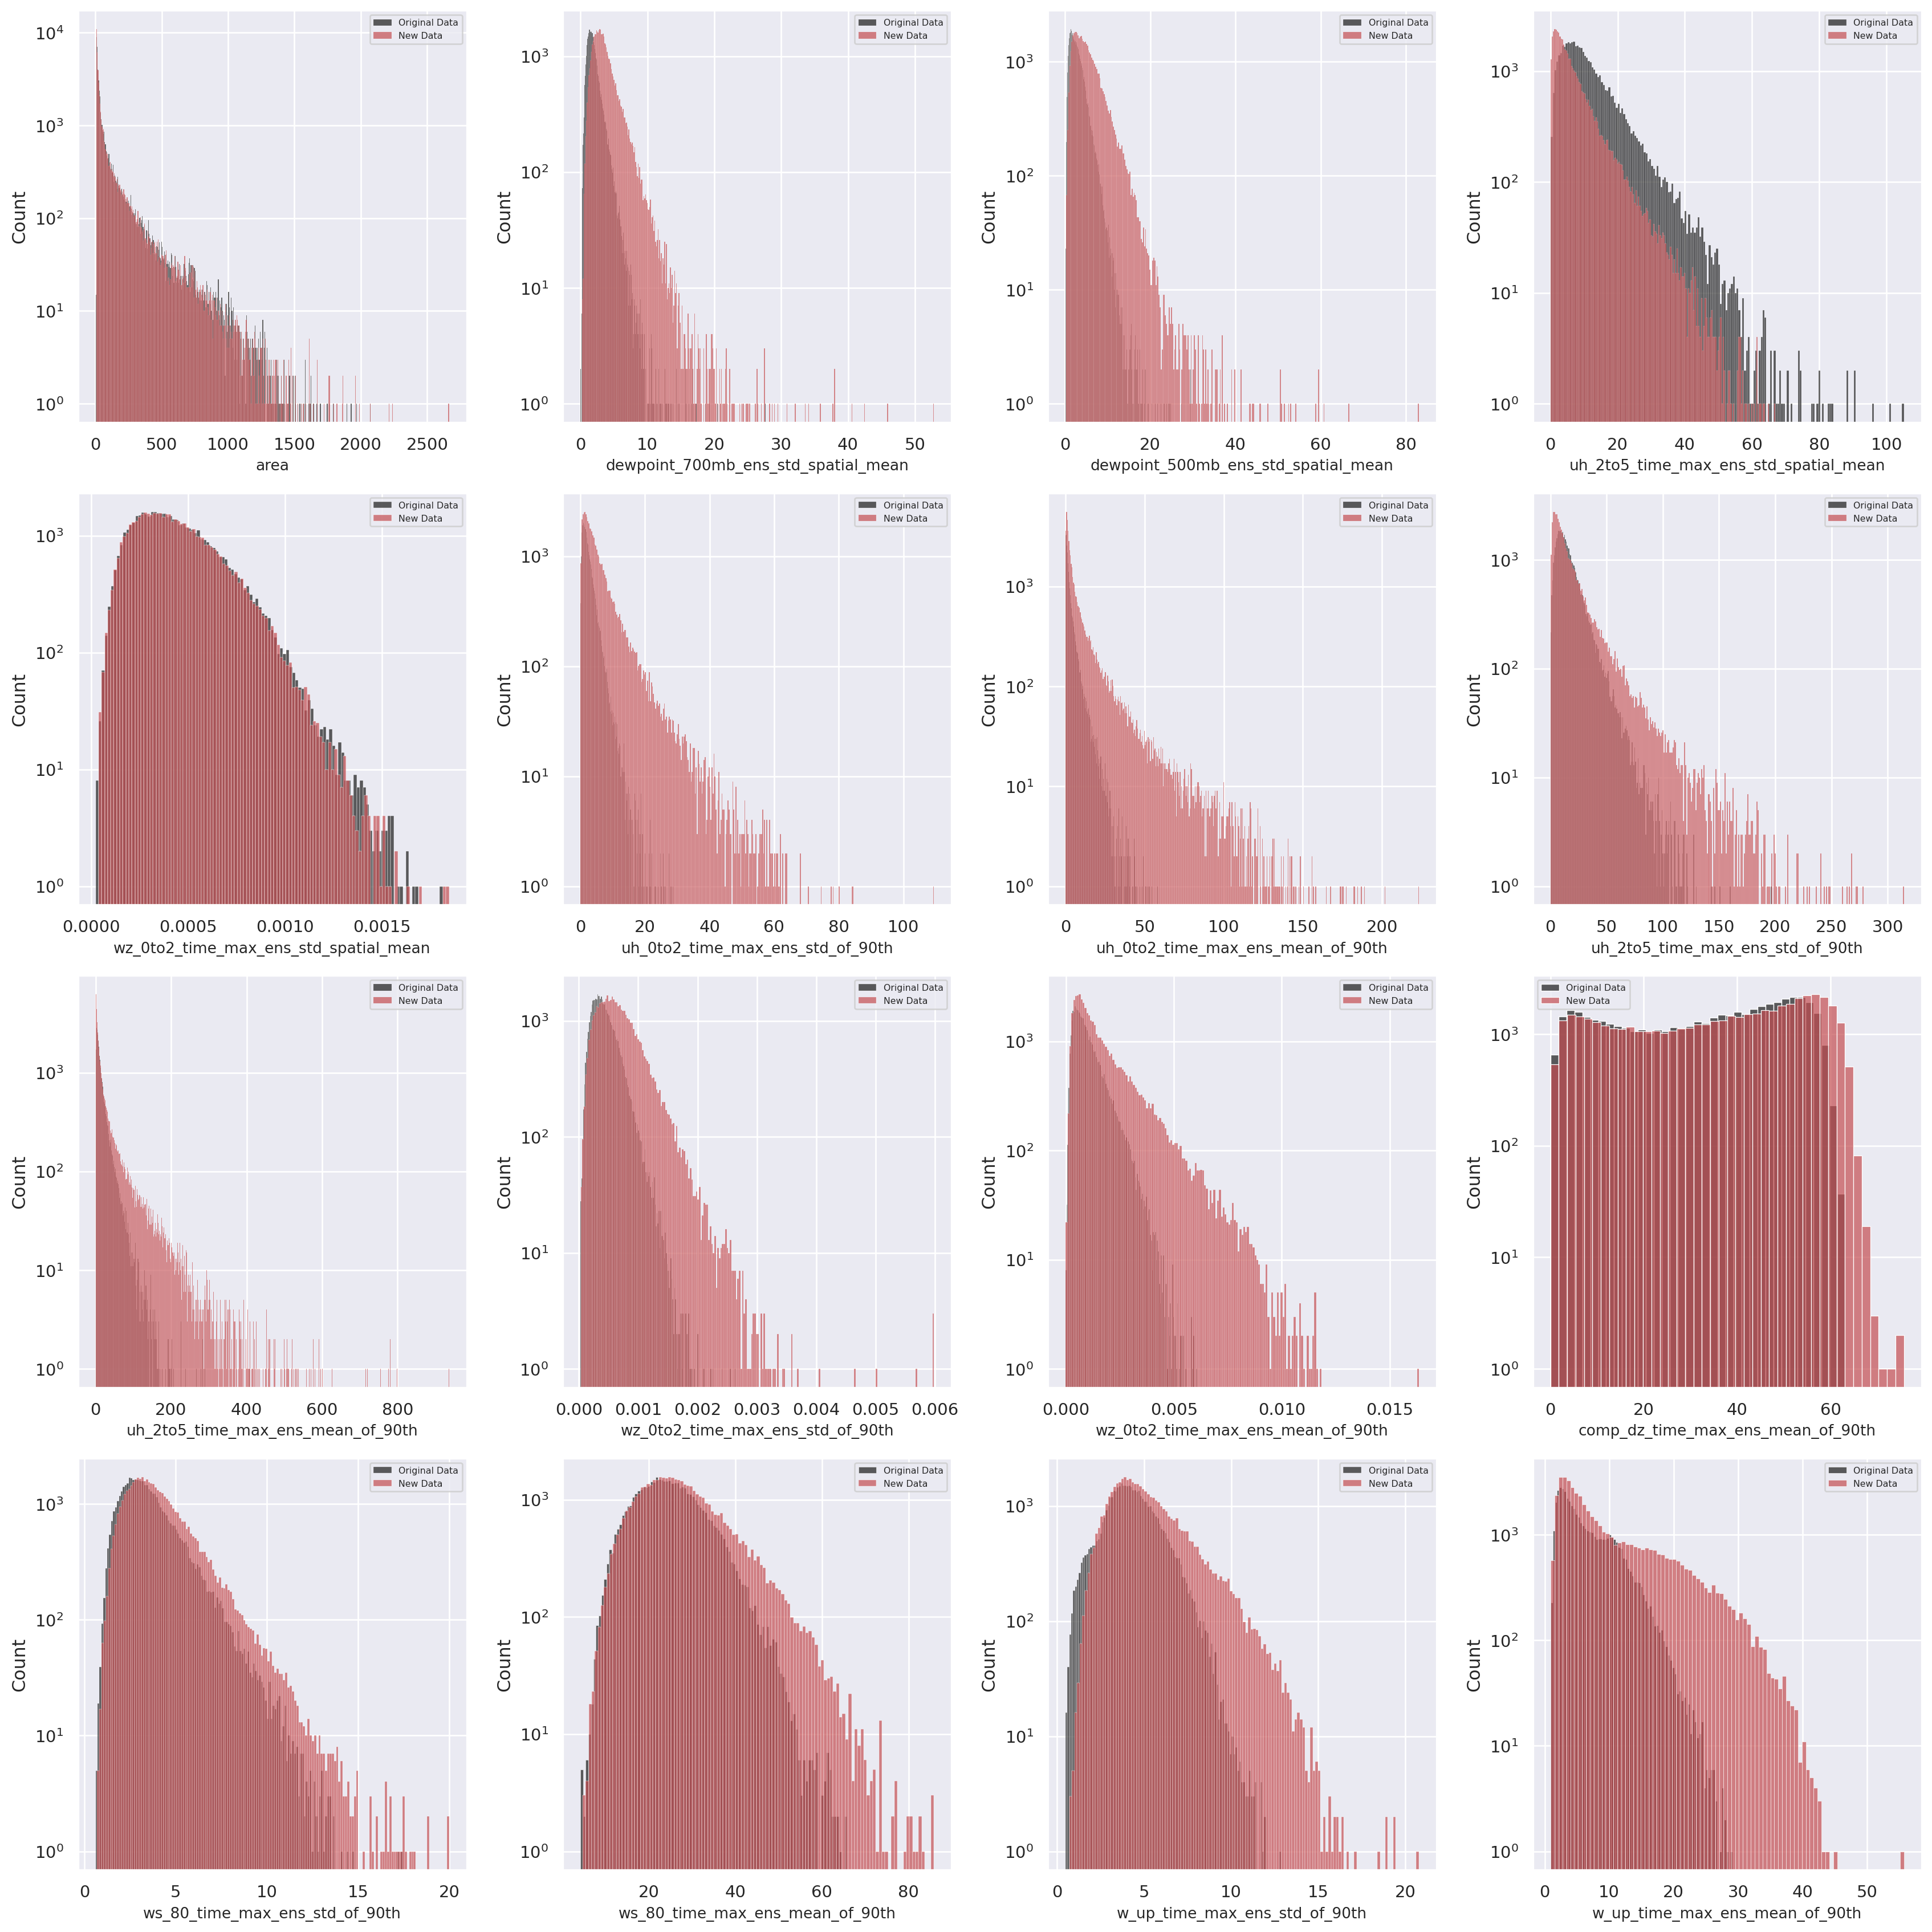

In [67]:
sns.set_theme()

f, axes = plt.subplots(dpi=190, figsize=(18,18), nrows=4, ncols=4)

i = 32

features = ['area'] + different_features[i:i+16+1]


for ax, feature in zip(axes.flat, features):
    data = X_train[feature]
    new_data = X_train_new[name_changer(feature)]
    
    sns.histplot(subsampler(data), ax=ax, alpha=0.7, color='k', label='Original Data', 
                  log_scale=(False, True))
    
    sns.histplot(subsampler(new_data), ax=ax,  alpha=0.7, color='r', label='New Data', 
                 log_scale=(False, True))
    
    ax.legend(fontsize=6)
    name = feature.split('_time')[0].split('ens')[0].replace('_', ' ').upper()
    
    
    ax.set_xlabel(feature, fontsize=10)
    
plt.tight_layout()

In [59]:
inds = np.where(X_train_new['w_up__time_max__amp_ens_mean'] > 35)

In [60]:
inds

(array([  1778,   1818,   1876, ..., 311506, 311566, 311630]),)

In [64]:
train_dates_new.values[inds]

array(['20170504', '20170504', '20170504', ..., '20190528', '20190528',
       '20190528'], dtype=object)

In [62]:
len(X_train_new)

319678